In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from torch.utils.data import DataLoader

from NICE import NICE, StandardLogistic
from plot import plot_results_NICE

In [2]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

mps


In [10]:
# Hyperparameters
NUM_EPOCHS = 400
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

**Loading the data**

The true (unknown) data distribution

In [4]:
# Data distribution:
mnist_transforms = transforms.Compose([
    transforms.ToTensor(),
])
binary_mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=mnist_transforms)
binary_mnist_loader = DataLoader(binary_mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

**Creating a model**

In [12]:
# Model
# prior = StandardLogistic()
# model = NICE(num_coupling_layers=5, input_dim=28*28, hidden_dim=256, num_m_layers=3, prior=prior).to(device)
model = torch.load(f'./weights/epoch_{300}_NICE.pth', map_location=device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Visualizing model's samples before training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


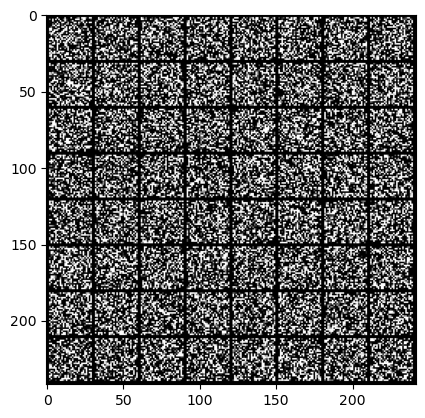

In [6]:
plot_results_NICE(model)

**Training the model**

In [7]:
losses = []

In [11]:
def uniform_dequantization(x):
    noise = torch.rand_like(x, device=x.device)
    # Transformaing the pixels back to [0, 255] range, then adding noise and transforming bakc
    return (x * 255.0 + noise) / 255.0

# Trained on collab
for epoch in range(NUM_EPOCHS):
    avg_loss = []
    for batch_idx, (image_batch, _) in enumerate(binary_mnist_loader):
        # Data gymnastics
        image_batch = uniform_dequantization(image_batch.to(device))

        # Loss
        loss = model.get_loss(image_batch)
        avg_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Making an update
        optimizer.step()

    avg_loss = torch.mean(torch.tensor(avg_loss))
    if epoch % 10 == 0:
        print('Epoch %d\t Loss=%.5f' % (epoch, avg_loss))
    if epoch % 50 == 0:
        torch.save(model, f'./weights/epoch_{epoch}_NICE.pth')
    losses.append(avg_loss)

Visualizing model's samples after training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


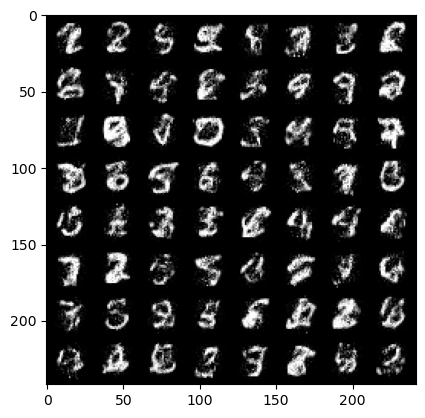

In [13]:
plot_results_NICE(model)

In [14]:
# Saving the model
torch.save(model, f'./weights/epoch_{NUM_EPOCHS}_NICE.pth')